# Experiment 3

In [1]:
import pandas as pd
import numpy as np

import quantstats as qs
from tinycta.port import build_portfolio

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True).ffill()

We use the system:
$$\mathrm{CashPosition}=\frac{f(\mathrm{Price})}{\mathrm{Volatility(Returns)}}$$

This is very problematic:
* Prices may live on very different scales, hence trying to find a more universal function $f$ is almost impossible. The sign-function was a good choice as the results don't depend on the scale of the argument.
* Price may come with all sorts of spikes/outliers/problems.

We need a simple price filter process
* We compute volatility-adjusted returns, filter them and compute prices from those returns. 
* Don't call it Winsorizing in Switzerland. We apply Huber functions. 


In [3]:
def filter(price, volatility=32,clip=4.2, min_periods=300):    
    r = np.log(price).diff()
    vola = r.ewm(com=volatility, min_periods=min_periods).std()
    price_adj = (r/vola).clip(-clip, clip).cumsum()
    return price_adj

### Oscillators
* All prices are now following a standard arithmetic Brownian motion with std $1$.
* What we want is the difference of two moving means (exponentially weighted) to have a constant std regardless of the two lengths.
* An oscillator is the **scaled difference of two moving averages**.


In [4]:
def osc(prices, fast=32, slow=96, scaling=True):
    diff = prices.ewm(com=fast-1).mean() - prices.ewm(com=slow-1).mean()
    if scaling:
        s = diff.std()
    else:
        s = 1

    return diff/s

In [5]:
from numpy.random import randn

price = pd.Series(data=randn(100000)).cumsum()

o = osc(price, 40, 200, scaling=True)
print("The std for the oscillator (Should be close to 1.0):")
print(np.std(o))

The std for the oscillator (Should be close to 1.0):
0.9999949999874997


In [6]:
#from pycta.signal import osc

# take two moving averages and apply tanh
def f(price, slow=96, fast=32, vola=96, clip=3):
    # construct a fake-price, those fake-prices have homescedastic returns
    price_adj = filter(price, volatility=vola, clip=clip)
    # compute mu
    mu = np.tanh(osc(price_adj, fast=fast, slow=slow))
    return mu/price.pct_change().ewm(com=slow, min_periods=300).std()

In [7]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
left_box = VBox([Label("Fast Moving Average"), Label("Slow Moving Average"), Label("Volatility"), Label("Winsorizing")])
right_box = VBox([fast, slow, vola, winsor])
HBox([left_box, right_box])

In [9]:
portfolio = build_portfolio(prices=prices, 
                            cashposition=1e6*f(prices, 
                                               slow=slow.value, 
                                               fast=fast.value, 
                                               vola=vola.value, 
                                               clip=winsor.value))

/Users/a13069q/github/cs/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: >

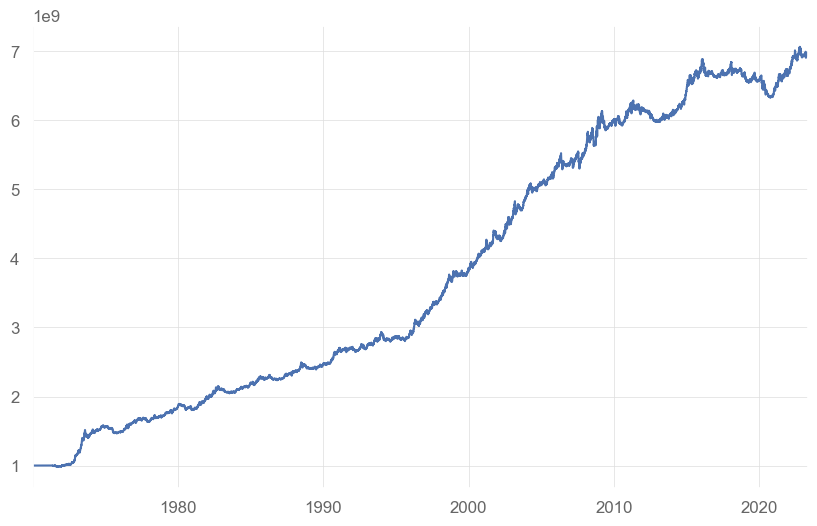

In [10]:
capital = 1e9
a = portfolio.nav(aum=capital)
a.plot()

                    Strategy
------------------  ----------
Start Period        1970-01-02
End Period          2023-04-26
Risk-Free Rate      0.0%
Time in Market      97.0%

Cumulative Return   598.11%
CAGR﹪              2.55%

Sharpe              1.09
Prob. Sharpe Ratio  100.0%
Sortino             1.59
Sortino/√2          1.13
Omega               1.21

Max Drawdown        -8.04%
Longest DD Days     2274

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.3

Payoff Ratio        1.01
Profit Factor       1.21
Common Sense Ratio  1.28
CPC Index           0.67
Tail Ratio          1.06
Outlier Win Ratio   3.93
Outlier Loss Ratio  3.74

MTD                 0.39%
3M                  0.79%
6M                  -0.63%
YTD                 0.4%
1Y                  1.23%
3Y (ann.)           1.82%
5Y (ann.)           0.54%
10Y (ann.)          1.01%
All-time (ann.)     2.55%

Avg. Drawdown       -0.72%
Avg. Drawdown Days  40
Recovery Factor     24.54
Ulcer Index         0.02
Serenity Index      3.76


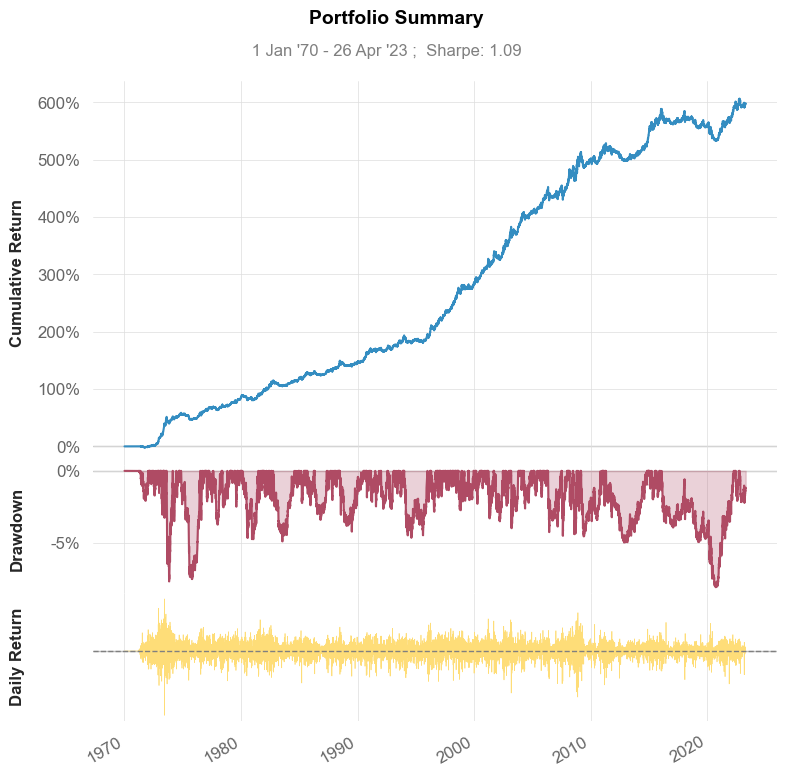

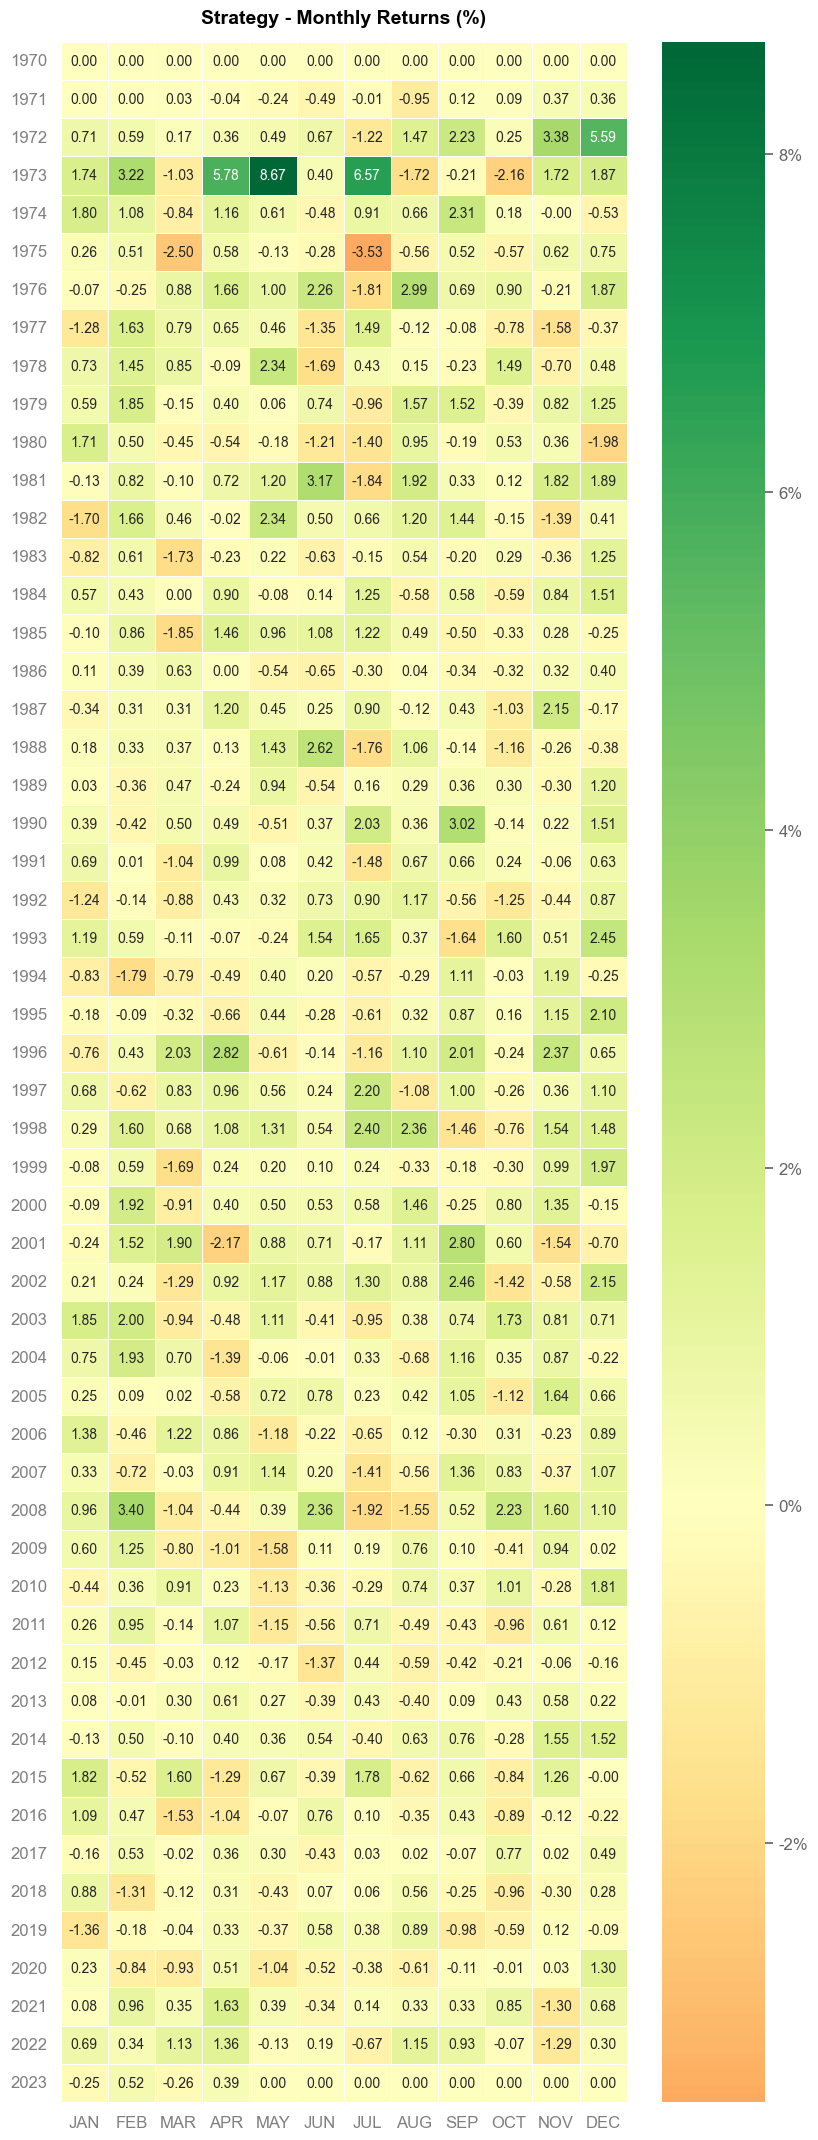

In [12]:
qs.reports.basic(a)